# IEEE-CIS Fraud Detection -- Model [Ensemble]

In [1]:
import pandas as pd
import numpy as np
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
from ml import simple

## Blending

In [13]:
sub = simple.Blend(['./Output/LGBM_model_1.csv', './Output/safe_box.csv'], 
                   'TransactionID', 'isFraud', './Output/blend01.csv')

In [14]:
sub = simple.Blend(['./Output/blend01.csv', './Output/XGB_model_1.csv'], 
                   'TransactionID', 'isFraud', './Output/blend02.csv')

In [15]:
sub = simple.Blend(['./Output/blend02.csv', './Output/random_forest_1.csv'], 
                   'TransactionID', 'isFraud', './Output/blend03.csv')

In [7]:
sub = simple.Blend(['./Output/LGB_cv_1_9325.csv', './Output/XGB_cv_1.csv'], 
                   'TransactionID', 'isFraud', './Output/blend05.csv')

In [9]:
sub = simple.Blend(['./Output/blend05.csv', './Output/DT_cv_1.csv'], 
                   'TransactionID', 'isFraud', './Output/blend06.csv')

## Stacking

In [5]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, auc
import lightgbm as lgb
from sklearn import model_selection
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

### blend02, blend05 and lgb_cv_1

In [71]:
blend02 = pd.read_csv('./Output/blend02_9354.csv', index_col=0)
blend05 = pd.read_csv('./Output/blend05_9373.csv', index_col=0)
lgb_1 = pd.read_csv('./Output/LGB_cv_1_9325.csv', index_col=0)

In [72]:
concat_sub = pd.concat([blend02, blend05, lgb_1], axis=1)

In [16]:
cols = list(map(lambda x: "ieee" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
ncol = concat_sub.shape[1]
concat_sub.head()

,TransactionID,ieee0,ieee1,ieee2
0,3663549,0.001947,0.003053,0.000522
1,3663550,0.003701,0.004310,0.003528
2,3663551,0.003232,0.008732,0.009337
3,3663552,0.004946,0.006856,0.003387
4,3663553,0.006041,0.003289,0.002760


In [23]:
concat_sub_rank = concat_sub.iloc[:,1:ncol].copy()
concat_sub_rank.head()
for _ in range(ncol-1):
    concat_sub_rank.iloc[:,_] = concat_sub_rank.iloc[:,_].rank(method ='average')
concat_sub_rank.describe()

,ieee0,ieee1,ieee2
count,506691.00000,506691.00000,506691.00000
mean,253346.00000,253346.00000,253346.00000
std,146269.23696,146269.23696,146269.23696
min,1.00000,1.00000,1.00000
25%,126673.50000,126673.50000,126673.50000
50%,253346.00000,253346.00000,253346.00000
75%,380018.50000,380018.50000,380018.50000
max,506691.00000,506691.00000,506691.00000


In [24]:
concat_sub.iloc[:,1:ncol].corr()

,ieee0,ieee1,ieee2
ieee0,1.000000,0.962840,0.950081
ieee1,0.962840,1.000000,0.984855
ieee2,0.950081,0.984855,1.000000


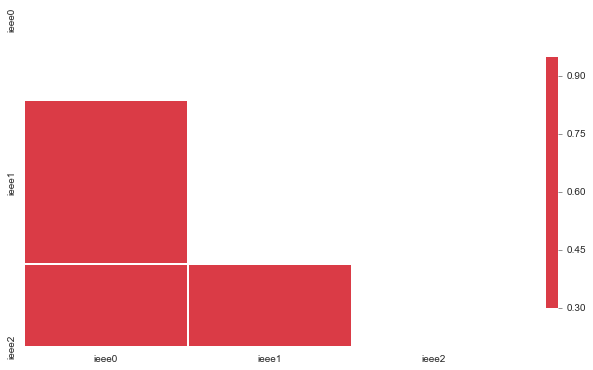

In [25]:
corr = concat_sub.iloc[:,1:7].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
# get the data fields ready for stacking
concat_sub['ieee_max'] = concat_sub.iloc[:, 1:ncol].max(axis=1)
concat_sub['ieee_min'] = concat_sub.iloc[:, 1:ncol].min(axis=1)
concat_sub['ieee_mean'] = concat_sub.iloc[:, 1:ncol].mean(axis=1)
concat_sub['ieee_median'] = concat_sub.iloc[:, 1:ncol].median(axis=1)

In [27]:
concat_sub.describe()

,TransactionID,ieee0,ieee1,ieee2,ieee_max,ieee_min,ieee_mean,ieee_median
count,5.066910e+05,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000
mean,3.916894e+06,0.027913,0.028470,0.027969,0.034674,0.021991,0.028117,0.027687
std,1.462692e+05,0.105388,0.104192,0.109547,0.116679,0.095101,0.105160,0.105946
min,3.663549e+06,0.000857,0.001346,0.000176,0.001346,0.000176,0.000893,0.000857
25%,3.790222e+06,0.003061,0.003814,0.002285,0.004314,0.002079,0.003281,0.003175
50%,3.916894e+06,0.005731,0.006557,0.004788,0.007739,0.004035,0.005907,0.005697
75%,4.043566e+06,0.012496,0.013674,0.011712,0.017066,0.008941,0.012886,0.012350
max,4.170239e+06,0.989438,0.993882,0.996434,0.996434,0.986017,0.990923,0.993882


#### Stacking: mean

In [28]:
concat_sub['isFraud'] = concat_sub['ieee_mean']
concat_sub[['TransactionID', 'isFraud']].to_csv('./Output/stack_mean.csv', 
                                        index=False, float_format='%.6f')

#### Stacking: median

In [30]:
concat_sub['isFraud'] = concat_sub['ieee_median']
concat_sub[['TransactionID', 'isFraud']].to_csv('./Output/stack_median.csv', 
                                        index=False, float_format='%.6f')

In [31]:
cutoff_lo = 0.8
cutoff_hi = 0.2

#### Pushout + Median Stacking

In [32]:
concat_sub['isFraud'] = np.where(np.all(concat_sub.iloc[:,1:ncol] > cutoff_lo, axis=1), 1, 
                                    np.where(np.all(concat_sub.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             0, concat_sub['ieee_median']))
concat_sub[['TransactionID', 'isFraud']].to_csv('./Output/stack_pushout_median.csv', 
                                        index=False, float_format='%.6f')

#### MinMax + Mean Stacking

In [33]:
concat_sub['isFraud'] = np.where(np.all(concat_sub.iloc[:,1:ncol] > cutoff_lo, axis=1), 
                                    concat_sub['ieee_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             concat_sub['ieee_min'], 
                                             concat_sub['ieee_mean']))
concat_sub[['TransactionID', 'isFraud']].to_csv('./Output/stack_minmax_mean.csv', 
                                        index=False, float_format='%.6f')

#### MinMax + Median Stacking

In [34]:
concat_sub['isFraud'] = np.where(np.all(concat_sub.iloc[:,1:ncol] > cutoff_lo, axis=1), 
                                    concat_sub['ieee_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             concat_sub['ieee_min'], 
                                             concat_sub['ieee_median']))
concat_sub[['TransactionID', 'isFraud']].to_csv('./Output/stack_minmax_median.csv', 
                                        index=False, float_format='%.6f')

#### Median Rank

In [35]:
concat_sub['isFraud'] = concat_sub_rank.median(axis=1)
concat_sub['isFraud'] = (concat_sub['isFraud']-concat_sub['isFraud'].min())/(concat_sub['isFraud'].max() - concat_sub['isFraud'].min())
concat_sub[['TransactionID', 'isFraud']].to_csv('./Output/stack_median_rank.csv', index=False, float_format='%.8f')

#### Mean Rank

In [36]:
concat_sub['isFraud'] = concat_sub_rank.mean(axis=1)
concat_sub['isFraud'] = (concat_sub['isFraud']-concat_sub['isFraud'].min())/(concat_sub['isFraud'].max() - concat_sub['isFraud'].min())
concat_sub[['TransactionID', 'isFraud']].to_csv('./Output/stack_mean_rank.csv', index=False, float_format='%.8f')

### blend02, blend05 and lgb_cv_1,  lgb_undersample, lgb_oversample

In [79]:
lgb_undersample = pd.read_csv('./Output/lgb_undersample.csv', index_col=0)
lgb_oversample = pd.read_csv('./Output/lgb_oversample.csv', index_col=0)

In [106]:
concat_sub1 = pd.concat([concat_sub, lgb_undersample, lgb_oversample], axis=1)

In [107]:
cols = list(map(lambda x: "ieee" + str(x), range(len(concat_sub1.columns))))
concat_sub1.columns = cols
concat_sub1.reset_index(inplace=True)
ncol = concat_sub1.shape[1]
concat_sub1.head()

,TransactionID,ieee0,ieee1,ieee2,ieee3,ieee4
0,3663549,0.001947,0.003053,0.000522,0.008641,0.207379
1,3663550,0.003701,0.004310,0.003528,0.019297,0.463138
2,3663551,0.003232,0.008732,0.009337,0.041603,0.998464
3,3663552,0.004946,0.006856,0.003387,0.033648,0.807542
4,3663553,0.006041,0.003289,0.002760,0.019183,0.460392


In [108]:
concat_sub1_rank = concat_sub1.iloc[:,1:ncol].copy()
concat_sub1_rank.head()
for _ in range(ncol-1):
    concat_sub1_rank.iloc[:,_] = concat_sub1_rank.iloc[:,_].rank(method ='average')
concat_sub1_rank.describe()

,ieee0,ieee1,ieee2,ieee3,ieee4
count,506691.00000,506691.00000,506691.00000,506691.00000,506691.00000
mean,253346.00000,253346.00000,253346.00000,253346.00000,253346.00000
std,146269.23696,146269.23696,146269.23696,146269.23696,146269.23696
min,1.00000,1.00000,1.00000,1.00000,1.00000
25%,126673.50000,126673.50000,126673.50000,126673.50000,126673.50000
50%,253346.00000,253346.00000,253346.00000,253346.00000,253346.00000
75%,380018.50000,380018.50000,380018.50000,380018.50000,380018.50000
max,506691.00000,506691.00000,506691.00000,506691.00000,506691.00000


In [109]:
# get the data fields ready for stacking
concat_sub1['ieee_max'] = concat_sub1.iloc[:, 1:ncol].max(axis=1)
concat_sub1['ieee_min'] = concat_sub1.iloc[:, 1:ncol].min(axis=1)
concat_sub1['ieee_mean'] = concat_sub1.iloc[:, 1:ncol].mean(axis=1)
concat_sub1['ieee_median'] = concat_sub1.iloc[:, 1:ncol].median(axis=1)

In [110]:
concat_sub1.head()

,TransactionID,ieee0,ieee1,ieee2,ieee3,ieee4,ieee_max,ieee_min,ieee_mean,ieee_median
0,3663549,0.001947,0.003053,0.000522,0.008641,0.207379,0.207379,0.000522,0.044308,0.003053
1,3663550,0.003701,0.004310,0.003528,0.019297,0.463138,0.463138,0.003528,0.098795,0.004310
2,3663551,0.003232,0.008732,0.009337,0.041603,0.998464,0.998464,0.003232,0.212274,0.009337
3,3663552,0.004946,0.006856,0.003387,0.033648,0.807542,0.807542,0.003387,0.171276,0.006856
4,3663553,0.006041,0.003289,0.002760,0.019183,0.460392,0.460392,0.002760,0.098333,0.006041


#### Stacking: mean

In [111]:
concat_sub1['isFraud'] = concat_sub1['ieee_mean']
concat_sub1[['TransactionID', 'isFraud']].to_csv('./Output/stack_mean_1.csv', 
                                        index=False, float_format='%.6f')

#### Stacking: median

In [112]:
concat_sub1['isFraud'] = concat_sub1['ieee_median']
concat_sub1[['TransactionID', 'isFraud']].to_csv('./Output/stack_median_1.csv', 
                                        index=False, float_format='%.6f')

In [113]:
cutoff_lo = 0.8
cutoff_hi = 0.2

#### Pushout + Median Stacking

In [114]:
concat_sub1['isFraud'] = np.where(np.all(concat_sub1.iloc[:,1:ncol] > cutoff_lo, axis=1), 1, 
                                    np.where(np.all(concat_sub1.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             0, concat_sub1['ieee_median']))
concat_sub1[['TransactionID', 'isFraud']].to_csv('./Output/stack_pushout_median_1.csv', 
                                        index=False, float_format='%.6f')

#### MinMax + Mean Stacking

In [115]:
concat_sub1['isFraud'] = np.where(np.all(concat_sub1.iloc[:,1:ncol] > cutoff_lo, axis=1), 
                                    concat_sub1['ieee_max'], 
                                    np.where(np.all(concat_sub1.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             concat_sub1['ieee_min'], 
                                             concat_sub1['ieee_mean']))
concat_sub1[['TransactionID', 'isFraud']].to_csv('./Output/stack_minmax_mean_1.csv', 
                                        index=False, float_format='%.6f')

#### MinMax + Median Stacking

In [116]:
concat_sub1['isFraud'] = np.where(np.all(concat_sub1.iloc[:,1:ncol] > cutoff_lo, axis=1), 
                                    concat_sub1['ieee_max'], 
                                    np.where(np.all(concat_sub1.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             concat_sub1['ieee_min'], 
                                             concat_sub1['ieee_median']))
concat_sub1[['TransactionID', 'isFraud']].to_csv('./Output/stack_minmax_median_1.csv', 
                                        index=False, float_format='%.6f')

#### Median Rank

In [117]:
concat_sub1['isFraud'] = concat_sub1_rank.median(axis=1)
concat_sub1['isFraud'] = (concat_sub1['isFraud']-concat_sub1['isFraud'].min())/(concat_sub1['isFraud'].max() - concat_sub1['isFraud'].min())
concat_sub1[['TransactionID', 'isFraud']].to_csv('./Output/stack_median_rank_1.csv', index=False, float_format='%.8f')

#### Mean Rank

In [118]:
concat_sub1['isFraud'] = concat_sub1_rank.mean(axis=1)
concat_sub1['isFraud'] = (concat_sub1['isFraud']-concat_sub1['isFraud'].min())/(concat_sub1['isFraud'].max() - concat_sub1['isFraud'].min())
concat_sub1[['TransactionID', 'isFraud']].to_csv('./Output/stack_mean_rank_1.csv', index=False, float_format='%.8f')

### blend02, blend05 and lgb_cv_1,  lgb_undersample

In [119]:
concat_sub2 = pd.concat([concat_sub, lgb_undersample], axis=1)

In [120]:
cols = list(map(lambda x: "ieee" + str(x), range(len(concat_sub2.columns))))
concat_sub2.columns = cols
concat_sub2.reset_index(inplace=True)
ncol = concat_sub2.shape[1]
concat_sub2.head()

,TransactionID,ieee0,ieee1,ieee2,ieee3
0,3663549,0.001947,0.003053,0.000522,0.008641
1,3663550,0.003701,0.004310,0.003528,0.019297
2,3663551,0.003232,0.008732,0.009337,0.041603
3,3663552,0.004946,0.006856,0.003387,0.033648
4,3663553,0.006041,0.003289,0.002760,0.019183


In [121]:
concat_sub2_rank = concat_sub2.iloc[:,1:ncol].copy()
concat_sub2_rank.head()
for _ in range(ncol-1):
    concat_sub2_rank.iloc[:,_] = concat_sub2_rank.iloc[:,_].rank(method ='average')
concat_sub2_rank.describe()

,ieee0,ieee1,ieee2,ieee3
count,506691.00000,506691.00000,506691.00000,506691.00000
mean,253346.00000,253346.00000,253346.00000,253346.00000
std,146269.23696,146269.23696,146269.23696,146269.23696
min,1.00000,1.00000,1.00000,1.00000
25%,126673.50000,126673.50000,126673.50000,126673.50000
50%,253346.00000,253346.00000,253346.00000,253346.00000
75%,380018.50000,380018.50000,380018.50000,380018.50000
max,506691.00000,506691.00000,506691.00000,506691.00000


In [122]:
# get the data fields ready for stacking
concat_sub2['ieee_max'] = concat_sub2.iloc[:, 1:ncol].max(axis=1)
concat_sub2['ieee_min'] = concat_sub2.iloc[:, 1:ncol].min(axis=1)
concat_sub2['ieee_mean'] = concat_sub2.iloc[:, 1:ncol].mean(axis=1)
concat_sub2['ieee_median'] = concat_sub2.iloc[:, 1:ncol].median(axis=1)

In [123]:
concat_sub2.head()

,TransactionID,ieee0,ieee1,ieee2,ieee3,ieee_max,ieee_min,ieee_mean,ieee_median
0,3663549,0.001947,0.003053,0.000522,0.008641,0.008641,0.000522,0.003541,0.002500
1,3663550,0.003701,0.004310,0.003528,0.019297,0.019297,0.003528,0.007709,0.004005
2,3663551,0.003232,0.008732,0.009337,0.041603,0.041603,0.003232,0.015726,0.009034
3,3663552,0.004946,0.006856,0.003387,0.033648,0.033648,0.003387,0.012209,0.005901
4,3663553,0.006041,0.003289,0.002760,0.019183,0.019183,0.002760,0.007818,0.004665


#### Stacking: mean

In [124]:
concat_sub2['isFraud'] = concat_sub2['ieee_mean']
concat_sub2[['TransactionID', 'isFraud']].to_csv('./Output/stack_mean_2.csv', 
                                        index=False, float_format='%.6f')

#### Stacking: median

In [125]:
concat_sub2['isFraud'] = concat_sub2['ieee_median']
concat_sub2[['TransactionID', 'isFraud']].to_csv('./Output/stack_median_2.csv', 
                                        index=False, float_format='%.6f')

In [113]:
cutoff_lo = 0.8
cutoff_hi = 0.2

#### Pushout + Median Stacking

In [126]:
concat_sub2['isFraud'] = np.where(np.all(concat_sub2.iloc[:,1:ncol] > cutoff_lo, axis=1), 1, 
                                    np.where(np.all(concat_sub2.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             0, concat_sub2['ieee_median']))
concat_sub2[['TransactionID', 'isFraud']].to_csv('./Output/stack_pushout_median_2.csv', 
                                        index=False, float_format='%.6f')

#### MinMax + Mean Stacking

In [127]:
concat_sub2['isFraud'] = np.where(np.all(concat_sub2.iloc[:,1:ncol] > cutoff_lo, axis=1), 
                                    concat_sub2['ieee_max'], 
                                    np.where(np.all(concat_sub2.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             concat_sub2['ieee_min'], 
                                             concat_sub2['ieee_mean']))
concat_sub2[['TransactionID', 'isFraud']].to_csv('./Output/stack_minmax_mean_2.csv', 
                                        index=False, float_format='%.6f')

#### MinMax + Median Stacking

In [130]:
concat_sub2['isFraud'] = np.where(np.all(concat_sub2.iloc[:,1:ncol] > cutoff_lo, axis=1), 
                                    concat_sub2['ieee_max'], 
                                    np.where(np.all(concat_sub2.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             concat_sub2['ieee_min'], 
                                             concat_sub2['ieee_median']))
concat_sub2[['TransactionID', 'isFraud']].to_csv('./Output/stack_minmax_median_2.csv', 
                                        index=False, float_format='%.6f')

#### Median Rank

In [131]:
concat_sub2['isFraud'] = concat_sub2_rank.median(axis=1)
concat_sub2['isFraud'] = (concat_sub2['isFraud']-concat_sub2['isFraud'].min())/(concat_sub2['isFraud'].max() - concat_sub2['isFraud'].min())
concat_sub2[['TransactionID', 'isFraud']].to_csv('./Output/stack_median_rank_2.csv', index=False, float_format='%.8f')

#### Mean Rank

In [132]:
concat_sub2['isFraud'] = concat_sub2_rank.mean(axis=1)
concat_sub2['isFraud'] = (concat_sub2['isFraud']-concat_sub2['isFraud'].min())/(concat_sub2['isFraud'].max() - concat_sub2['isFraud'].min())
concat_sub2[['TransactionID', 'isFraud']].to_csv('./Output/stack_mean_rank_2.csv', index=False, float_format='%.8f')

In [6]:
cols_cat = ['id_13', 'id_14', 'M9', 'id_30', 'id_19', 'M8', 'addr2', 'M4', 'card1', 'M1', 'P_emaildomain_2', 'M7', 'M6', 'id_15', 'addr1', 'id_20',
            'card6', 'id_38', 'P_emaildomain', 'DeviceType', 'id_35', 'M5', 'ProductCD', 'card3', 'id_16', 'card5', 'id_33', 'DeviceInfo',
            'R_emaildomain', 'R_emaildomain_2', 'id_31', 'id_17', 'dist1', 'card4', 'card2']

In [ ]:
clfs = [lgb.LGBMClassifier(**lgb_params),
        xgb.XGBClassifier(**xgb_params), 
        RandomForestClassifier(**rf_params),
        ExtraTreesClassifier(), 
        DecisionTreeClassifier(), 
        AdaBoostClassifier()]
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=clfs, 
                          meta_classifier=lr)

In [ ]:
%%time
scores = []
score = 0

EPOCHS = 5
kf = KFold(n_splits = EPOCHS, shuffle = True)

for i, (train_idx, validation_idx) in enumerate(kf.split(train_features, train_target)):

    X_train, X_validation = train_features.iloc[train_idx, :], train_features.iloc[validation_idx, :]
    y_train, y_validation = train_target.iloc[train_idx], train_target.iloc[validation_idx]

    sclf.fit(X_train, y_train)  

    y_pred_train = sclf.predict_proba(X_validation)[:,1]
    score = roc_auc_score(y_validation, y_pred_train)
    scores.append(score)
    print('Validation AUC: ', score)

print("[%s] Accuracy: %0.2f (+/- %0.2f)" % (label, np.mean(scores), np.std(scores)))

In [ ]:
%%time
scores = []
score = 0
for clf, label in zip(clfs + [sclf], 
                      ['LGBM', 
                       'Xgboost',
                       'Random Forest', 
                       'Extra Trees',
                       'DecisionTree',
                       'Adaboost',
                       'StackingClassifier']):
    EPOCHS = 5
    kf = KFold(n_splits = EPOCHS, shuffle = True)
    
    for i, (train_idx, validation_idx) in enumerate(kf.split(train_features, train_target)):
        
        print(f'[{label}] Start training {i+1} fold')
    
        X_train, X_validation = train_features.iloc[train_idx, :], train_features.iloc[validation_idx, :]
        y_train, y_validation = train_target.iloc[train_idx], train_target.iloc[validation_idx]
 
        clf.fit(X_train, y_train)  
 
        y_pred_train = clf.predict_proba(X_validation)[:,1]
        score = roc_auc_score(y_validation, y_pred_train)
        scores.append(score)
        print('            Validation AUC: ', score)

    print("[%s] Accuracy: %0.2f (+/- %0.2f)" % (label, np.mean(scores), np.std(scores)))

## Reference
- https://www.kaggle.com/smerllo/identify-unique-cards-id